In [2]:
import IPython
import IPython.display
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pandas as pd
import numpy as np
import keras_tuner as kt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
import gc
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
import os

In [3]:
# for reproducibility
seed0=1337
np.random.seed(seed0) 
tf.keras.utils.set_random_seed(seed0)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(seed0)

In [4]:
#to avoid seeing shortened text data in pandas cell
pd.set_option('display.max_colwidth', None)

In [5]:
for dirname, _, filenames in os.walk('C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\cleaned_data.csv
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\compare_models.png
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\holidays_events.csv
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\model_df.csv
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\monthly_cleaned_data.csv
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\oil.csv
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\original_data.csv
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\results.csv
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\sample_submission.csv
C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting\statio

# Exploratory Data Analysis, Visualization, and Data Wrangling¶


In [6]:
# Reading datasets
train = pd.read_csv('C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\train.csv')
test = pd.read_csv('C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\test.csv')
holiday_events = pd.read_csv('C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\holidays_events.csv')
oil = pd.read_csv('C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\oil.csv')
stores = pd.read_csv('C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\stores.csv')
transactions = pd.read_csv('C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\transactions.csv')


In [7]:
#checking out dataset content and shape
display("Train",train.head(2),train.tail(2), train.shape, "*"*66)
display("Test",test.head(2),test.tail(2), test.shape, "*"*66)
display("Holiday Events",holiday_events.head(2),holiday_events.tail(2), holiday_events.shape, "*"*66)
display("Oil",oil.head(2),oil.tail(2), oil.shape, "*"*66)
display("Stores",stores.head(2),stores.tail(2), stores.shape, "*"*66)
display("Transactions",transactions.head(2),transactions.tail(1), transactions.shape, "*"*66)

'Train'

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0


,id,date,store_nbr,family,sales,onpromotion
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.0,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


(3000888, 6)

'******************************************************************'

'Test'

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0


,id,date,store_nbr,family,onpromotion
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


(28512, 5)

'******************************************************************'

'Holiday Events'

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


,date,type,locale,locale_name,description,transferred
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


(350, 6)

'******************************************************************'

'Oil'

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14


,date,dcoilwtico
1216,2017-08-30,45.96
1217,2017-08-31,47.26


(1218, 2)

'******************************************************************'

'Stores'

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13


,store_nbr,city,state,type,cluster
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


(54, 5)

'******************************************************************'

'Transactions'

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111


,date,store_nbr,transactions
83487,2017-08-15,54,802


(83488, 3)

'******************************************************************'

In [8]:
#converting date feature to datetime data type
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
holiday_events["date"] = pd.to_datetime(holiday_events.date)
oil["date"] = pd.to_datetime(oil.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Visualising time series data

In [9]:
#Generic helper function to plot time variant data
def plot_series(time, series, format="-", start=0, end=None):
    fig, ax = plt.subplots(figsize=(14,5))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.show()
    plt.close()

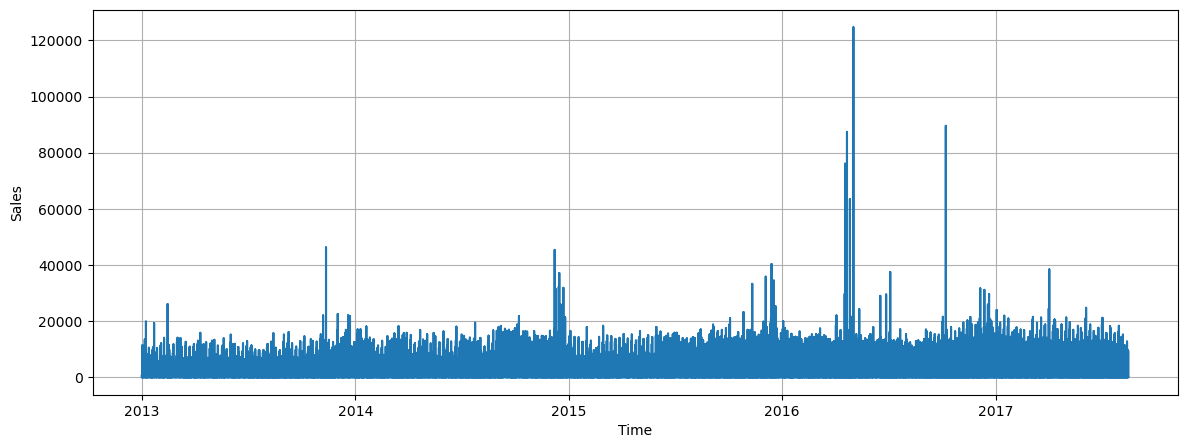

In [10]:
plot_series(train["date"], train["sales"], format="-", start=0, end=None)

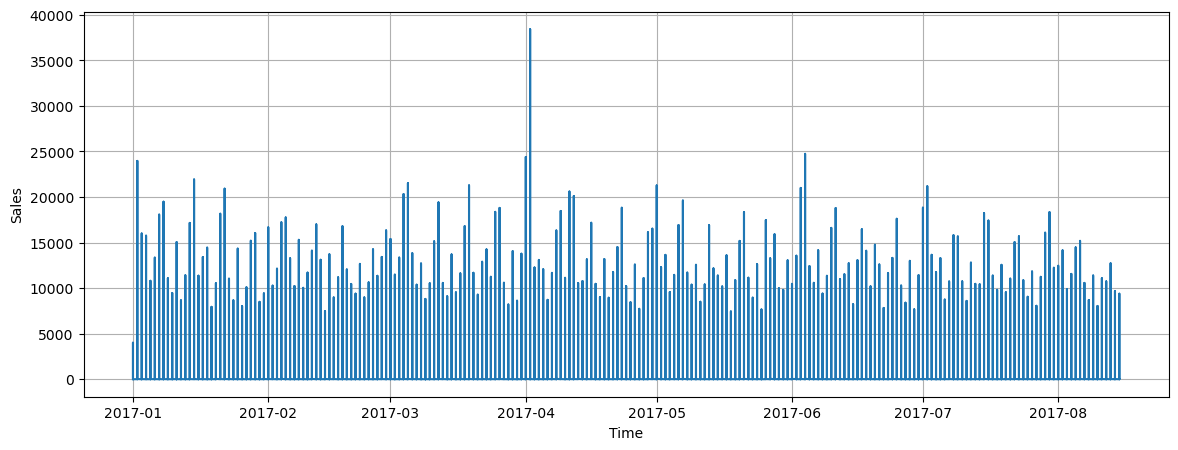

In [11]:
# Zooming into 2017
plot_series(train["date"], train["sales"], format="-",
            start=-len(train["date"][train["date"] >=pd.to_datetime("2017-01-01")]), end=None)


C:\Users\pc\AppData\Local\Temp\ipykernel_10064\4100293811.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


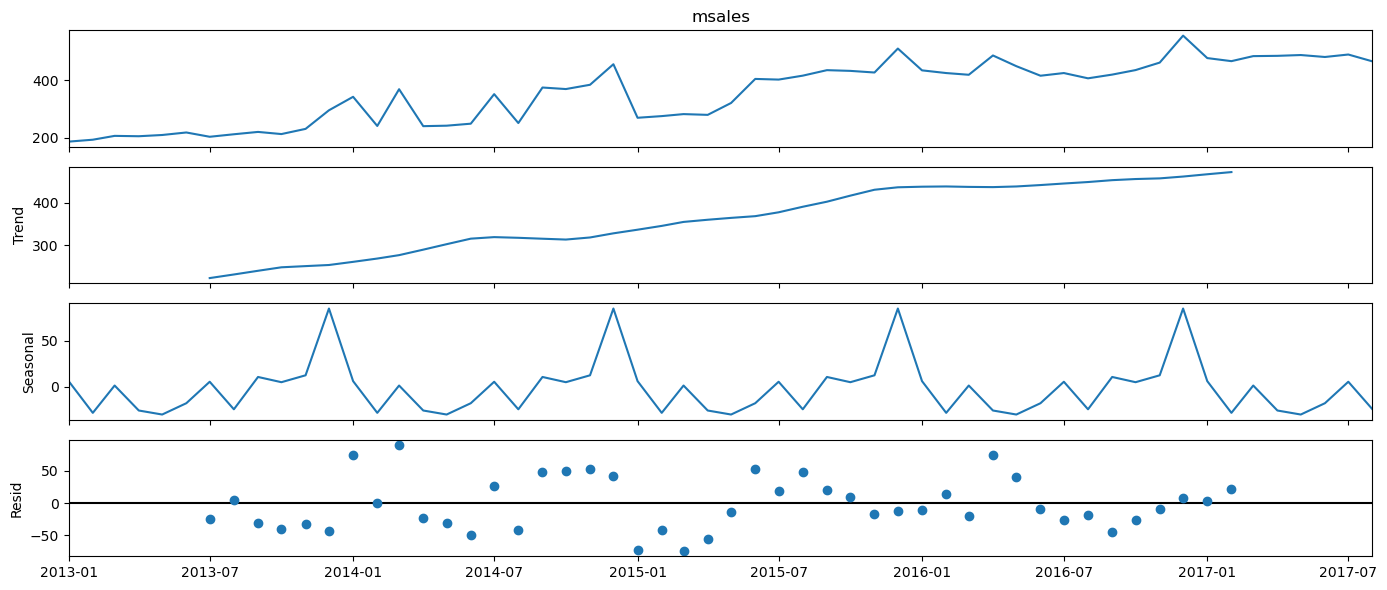

In [13]:
# checking trend seasonality and residuals
import statsmodels.api as sm
t_series = train.groupby(['date'])['sales'].agg(['mean']).reset_index().rename(columns={'mean': 'msales'})
t_series = t_series.set_index('date')
sample= t_series['msales'].resample('MS').mean()
decomposition = sm.tsa.seasonal_decompose(sample, model='additive')
fig = decomposition.plot()
fig.set_size_inches((14, 6))
fig.tight_layout()
plt.show()
plt.close()

# Joining holiday-oil-stores with train and test sets

Note: I won't use transactions data because it isn't available for test set and I don't want to dedicate time to extract features utilising it but it can certainly provide useful information and worth engineering in a deeper study.

In [14]:
# helper function to do merge datasets 
def joins(df,holiday_events,oil,stores):
    print(df.shape)
    holiday_events=holiday_events.drop_duplicates(subset=['date'], keep='last')
    df_holiday=pd.merge(df,holiday_events,how="left",on='date', validate="many_to_one")
    print(f"Shape after merging with holiday {df_holiday.shape}")
    df_holiday_oil=pd.merge(df_holiday,oil,how="left",on='date')
    print(f"Shape after merging with holiday + oil {df_holiday_oil.shape}")
    df_holiday_oil_stores=pd.merge(df_holiday_oil,stores,how="left",on="store_nbr",suffixes=("holiday","stores"))
    print(f"Shape after merging with holiday + oil + stores {df_holiday_oil_stores.shape}")
    return df_holiday_oil_stores

In [15]:
#merging datasets
train_merged=joins(train,holiday_events,oil,stores)
display(train_merged.head(1),train_merged.tail(1))
test_merged=joins(test,holiday_events,oil,stores)
display(test_merged.head(1),test_merged.tail(1))

(3000888, 6)
Shape after merging with holiday (3000888, 11)
Shape after merging with holiday + oil (3000888, 12)
Shape after merging with holiday + oil + stores (3000888, 16)


,id,date,store_nbr,family,sales,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


,id,date,store_nbr,family,sales,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6


(28512, 5)
Shape after merging with holiday (28512, 10)
Shape after merging with holiday + oil (28512, 11)
Shape after merging with holiday + oil + stores (28512, 15)


,id,date,store_nbr,family,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13


,id,date,store_nbr,family,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
28511,3029399,2017-08-31,9,SEAFOOD,0,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6


Extracting month and weekday

In [16]:
# extracting time features for train dataset
train_merged['day_of_week'] = train_merged['date'].dt.day_of_week
train_merged['day_of_week'] = train_merged['day_of_week']+1
train_merged['month'] = train_merged['date'].dt.month
train_merged['year'] = train_merged['date'].dt.year

In [17]:
# extracting time features for test dataset
test_merged['day_of_week'] = test_merged['date'].dt.day_of_week
test_merged['day_of_week'] = test_merged['day_of_week']+1
test_merged['month'] = test_merged['date'].dt.month
test_merged['year'] = test_merged['date'].dt.year

In [18]:
# printing basic properties of features
display(train_merged.describe(include="all").T,train_merged.isna().sum() )
display(test_merged.describe(include="all").T,test_merged.isna().sum())

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,3000888.0,NaN,NaN,NaN,1500443.5,0.0,750221.75,1500443.5,2250665.25,3000887.0,866281.891642
date,3000888,NaN,NaN,NaN,2015-04-24 08:27:04.703088384,2013-01-01 00:00:00,2014-02-26 18:00:00,2015-04-24 12:00:00,2016-06-19 06:00:00,2017-08-15 00:00:00,NaN
store_nbr,3000888.0,NaN,NaN,NaN,27.5,1.0,14.0,27.5,41.0,54.0,15.585787
family,3000888,33,AUTOMOTIVE,90936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,3000888.0,NaN,NaN,NaN,357.775749,0.0,0.0,11.0,195.84725,124717.0,1101.997721
onpromotion,3000888.0,NaN,NaN,NaN,2.60277,0.0,0.0,0.0,0.0,741.0,12.218882
typeholiday,449064,6,Holiday,263736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locale,449064,3,National,249480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locale_name,449064,22,Ecuador,249480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,449064,97,Carnaval,17820,NaN,NaN,NaN,NaN,NaN,NaN,NaN


id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
typeholiday    2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dcoilwtico      928422
city                 0
state                0
typestores           0
cluster              0
day_of_week          0
month                0
year                 0
dtype: int64

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,28512.0,NaN,NaN,NaN,3015143.5,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0,8230.849774
date,28512,NaN,NaN,NaN,2017-08-23 12:00:00,2017-08-16 00:00:00,2017-08-19 18:00:00,2017-08-23 12:00:00,2017-08-27 06:00:00,2017-08-31 00:00:00,NaN
store_nbr,28512.0,NaN,NaN,NaN,27.5,1.0,14.0,27.5,41.0,54.0,15.586057
family,28512,33,AUTOMOTIVE,864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
onpromotion,28512.0,NaN,NaN,NaN,6.965383,0.0,0.0,0.0,6.0,646.0,20.683952
typeholiday,1782,1,Holiday,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locale,1782,1,Local,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locale_name,1782,1,Ambato,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,1782,1,Fundacion de Ambato,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transferred,1782,1,False,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN


id                 0
date               0
store_nbr          0
family             0
onpromotion        0
typeholiday    26730
locale         26730
locale_name    26730
description    26730
transferred    26730
dcoilwtico      7128
city               0
state              0
typestores         0
cluster            0
day_of_week        0
month              0
year               0
dtype: int64

Changing transfered holidays to normal days

In [19]:
#checking value counts of holiday types
display(train_merged["typeholiday"].value_counts(dropna=False))
# checking categories of transferred feature of holiday dataset
display(train_merged["transferred"].unique())

typeholiday
NaN           2551824
Holiday        263736
Event           98010
Additional      58806
Transfer        16038
Work Day         8910
Bridge           3564
Name: count, dtype: int64

array([False, nan, True], dtype=object)

In [20]:
def transfer_holiday_fix(df):
    df["typeholiday"]=np.where(df["transferred"]==True,'NDay',df["typeholiday"])
    df["typeholiday"]=np.where(df["typeholiday"]=='Work Day','NDay',df["typeholiday"])
    df["typeholiday"]=df["typeholiday"].fillna("NDay")
    return df

In [21]:
train_merged=transfer_holiday_fix(train_merged)
test_merged=transfer_holiday_fix(test_merged)
# checking new structure of holiday type column
display(train_merged["typeholiday"].value_counts(dropna=False))
display(test_merged["typeholiday"].value_counts(dropna=False))

typeholiday
NDay          2576772
Holiday        247698
Event           98010
Additional      58806
Transfer        16038
Bridge           3564
Name: count, dtype: int64

typeholiday
NDay       26730
Holiday     1782
Name: count, dtype: int64

# Removing the key columns

In [22]:
#helper function to remove id columns used for joining datasets, 
# note I made decision not to use store_nbr, because I am not using transactions to extract features
# but it can work as category feature for certain models, 
# my decision was because it is an idendifier and useful information it contains also exist in store type and cluster
def select_relevant(df):
    print(f"shape before removing columns {df.shape}")
    features=["date","family","sales","onpromotion","typeholiday","dcoilwtico","city","state",
              "typestores","cluster","day_of_week","month","year"]
    if "sales" in df.columns:
        df= df[features]
    else:
        features.remove("sales")
        df= df[features]
    print(f"Shape after removing columns {df.shape}")
    return df

In [23]:
train_merged=select_relevant(train_merged)
test_merged=select_relevant(test_merged)

shape before removing columns (3000888, 19)
Shape after removing columns (3000888, 13)
shape before removing columns (28512, 18)
Shape after removing columns (28512, 12)


In [24]:
train_merged

,date,family,sales,onpromotion,typeholiday,dcoilwtico,city,state,typestores,cluster,day_of_week,month,year
0,2013-01-01,AUTOMOTIVE,0.000,0,Holiday,NaN,Quito,Pichincha,D,13,2,1,2013
1,2013-01-01,BABY CARE,0.000,0,Holiday,NaN,Quito,Pichincha,D,13,2,1,2013
2,2013-01-01,BEAUTY,0.000,0,Holiday,NaN,Quito,Pichincha,D,13,2,1,2013
3,2013-01-01,BEVERAGES,0.000,0,Holiday,NaN,Quito,Pichincha,D,13,2,1,2013
4,2013-01-01,BOOKS,0.000,0,Holiday,NaN,Quito,Pichincha,D,13,2,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,POULTRY,438.133,0,Holiday,47.57,Quito,Pichincha,B,6,2,8,2017
3000884,2017-08-15,PREPARED FOODS,154.553,1,Holiday,47.57,Quito,Pichincha,B,6,2,8,2017
3000885,2017-08-15,PRODUCE,2419.729,148,Holiday,47.57,Quito,Pichincha,B,6,2,8,2017
3000886,2017-08-15,SCHOOL AND OFFICE SUPPLIES,121.000,8,Holiday,47.57,Quito,Pichincha,B,6,2,8,2017


In [25]:
test_merged

,date,family,onpromotion,typeholiday,dcoilwtico,city,state,typestores,cluster,day_of_week,month,year
0,2017-08-16,AUTOMOTIVE,0,NDay,46.80,Quito,Pichincha,D,13,3,8,2017
1,2017-08-16,BABY CARE,0,NDay,46.80,Quito,Pichincha,D,13,3,8,2017
2,2017-08-16,BEAUTY,2,NDay,46.80,Quito,Pichincha,D,13,3,8,2017
3,2017-08-16,BEVERAGES,20,NDay,46.80,Quito,Pichincha,D,13,3,8,2017
4,2017-08-16,BOOKS,0,NDay,46.80,Quito,Pichincha,D,13,3,8,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,POULTRY,1,NDay,47.26,Quito,Pichincha,B,6,4,8,2017
28508,2017-08-31,PREPARED FOODS,0,NDay,47.26,Quito,Pichincha,B,6,4,8,2017
28509,2017-08-31,PRODUCE,1,NDay,47.26,Quito,Pichincha,B,6,4,8,2017
28510,2017-08-31,SCHOOL AND OFFICE SUPPLIES,9,NDay,47.26,Quito,Pichincha,B,6,4,8,2017


Fixing the issue with missing values in oil prices by interpolating nans and 0s at oil price

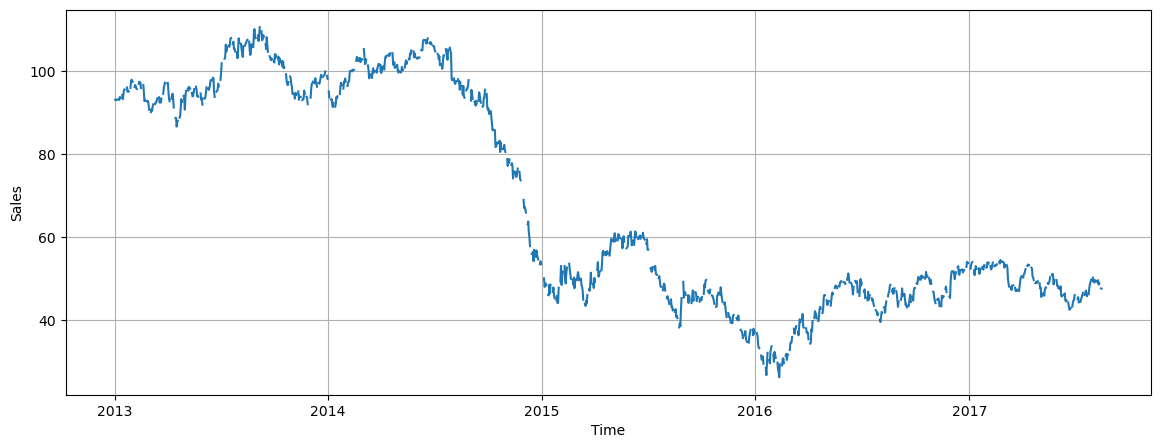

In [26]:
# plotting current distribution of oil price vs time
plot_series(train_merged["date"], train_merged["dcoilwtico"], format="-", start=0, end=None)


In [27]:
# helper function to interpolate oil price
def interpolate_oil(df):
    print(f"Shape before interpolating {df.shape}")
    df["dcoilwtico"]=np.where(df["dcoilwtico"] ==0, np.nan, df["dcoilwtico"])
    df.dcoilwtico.interpolate(limit_direction='both',inplace=True)
    print(f"Shape after interpolating {df.shape}")
    return df

In [28]:
train_merged=interpolate_oil(train_merged)
test_merged=interpolate_oil(test_merged)
display(f"Number of nan in train dataset oil price after interpolation {train_merged['dcoilwtico'].isna().sum()}")
display(f"Number of nan in test dataset oil price after interpolation {test_merged['dcoilwtico'].isna().sum()}")

Shape before interpolating (3000888, 13)
Shape after interpolating (3000888, 13)
Shape before interpolating (28512, 12)
Shape after interpolating (28512, 12)


'Number of nan in train dataset oil price after interpolation 0'

'Number of nan in test dataset oil price after interpolation 0'

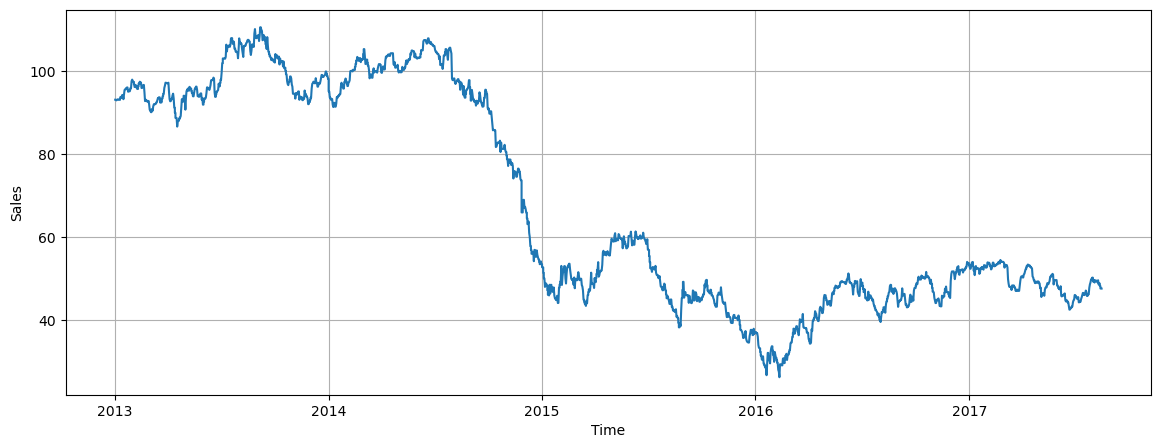

In [29]:
plot_series(train_merged["date"], train_merged["dcoilwtico"], format="-", start=0, end=None)


In [30]:
# globally setting sns to darkgrid theme
sns.set_theme(style="darkgrid")

In [31]:
# helper function to plot variation of sales vs time for each class in a feature
def plot_by_category(df,category):
    fig, ax = plt.subplots(figsize=(14,8))
    
    df_grouped=df.groupby(['date',category]).agg({'sales': 'mean'}).reset_index()
    sns.lineplot(data =df_grouped,  x="date", y="sales", hue=category, ax=ax, legend="brief")
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()

family


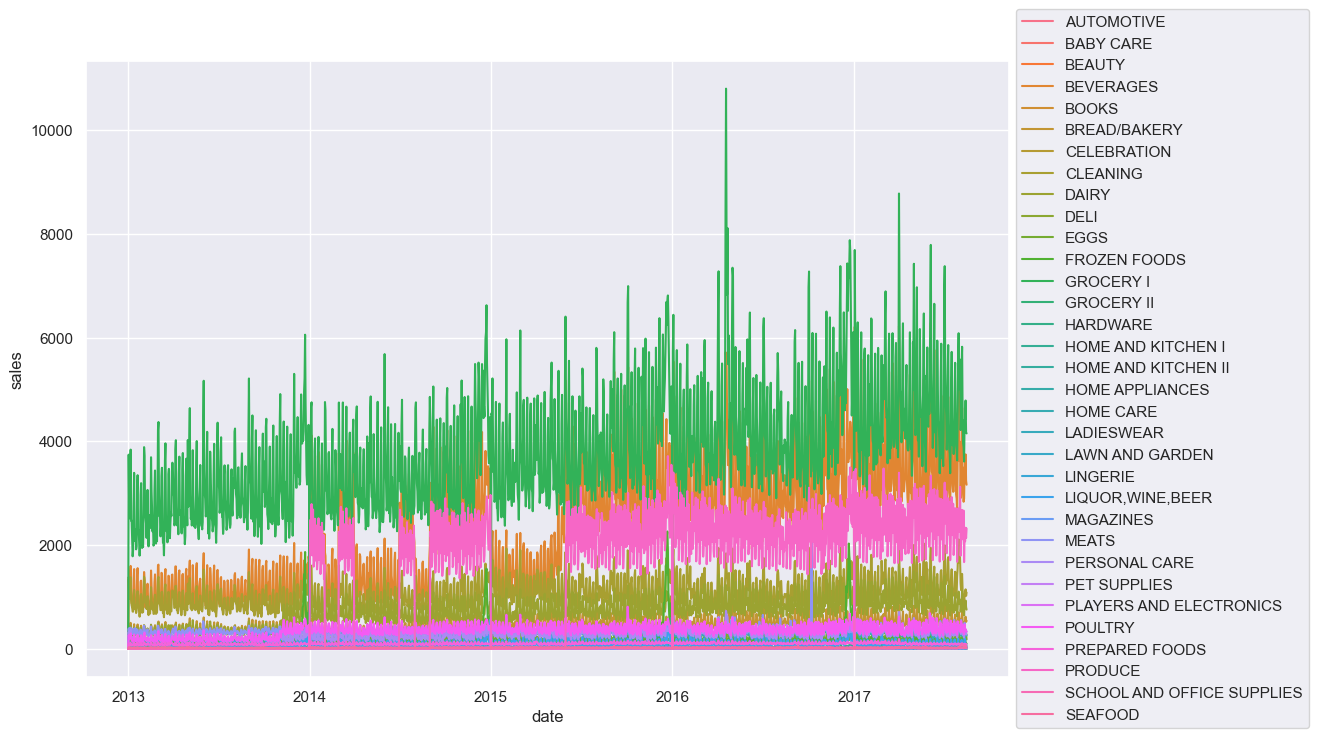

typeholiday


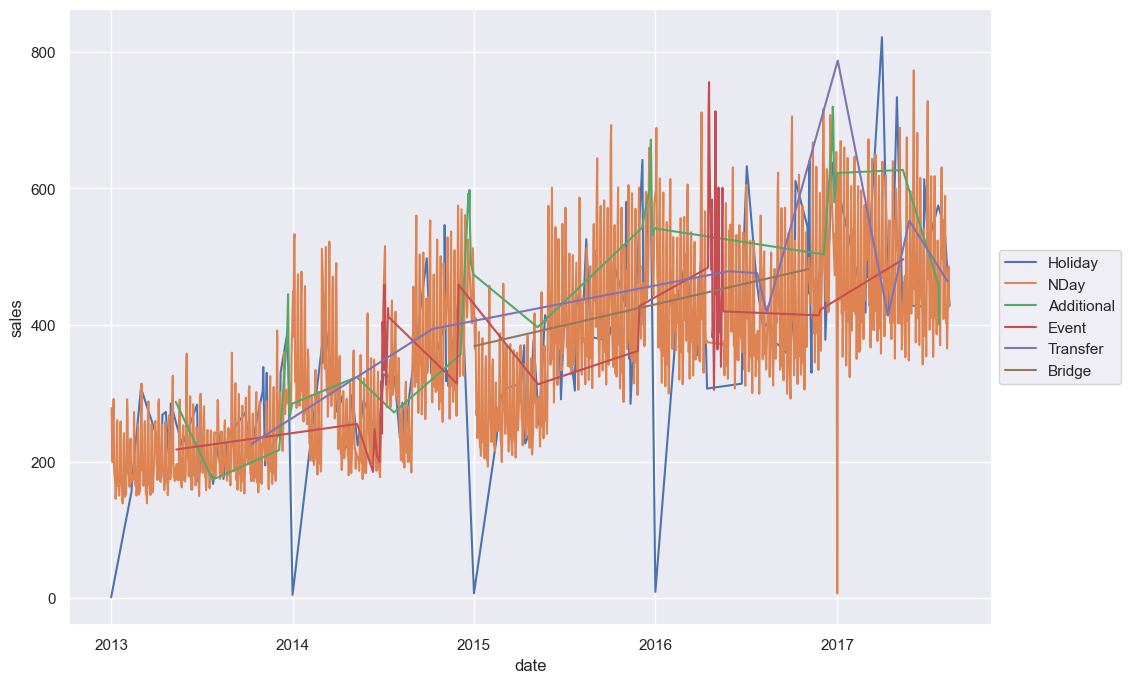

city


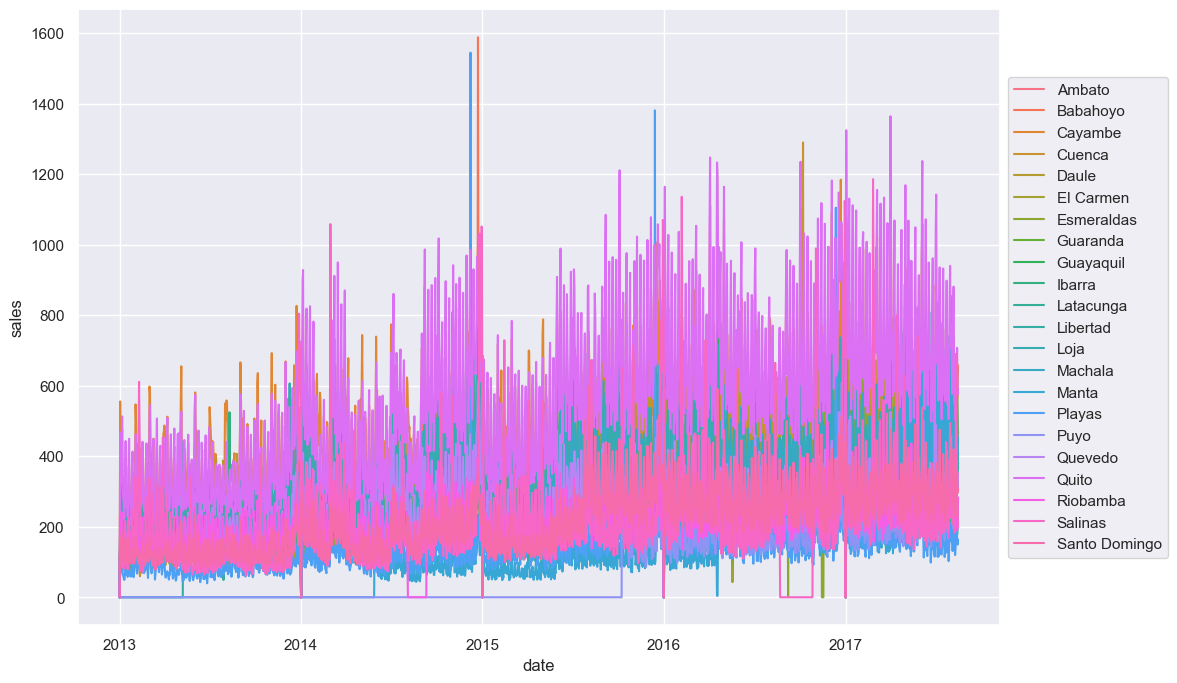

state


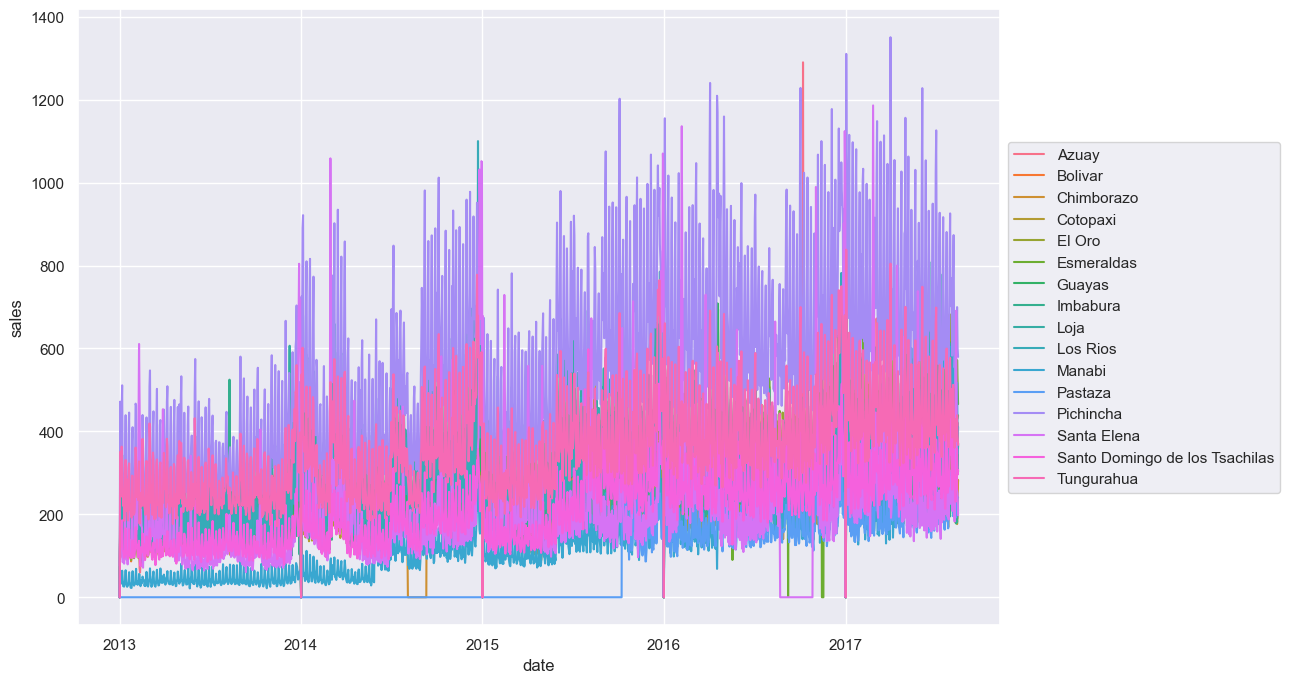

typestores


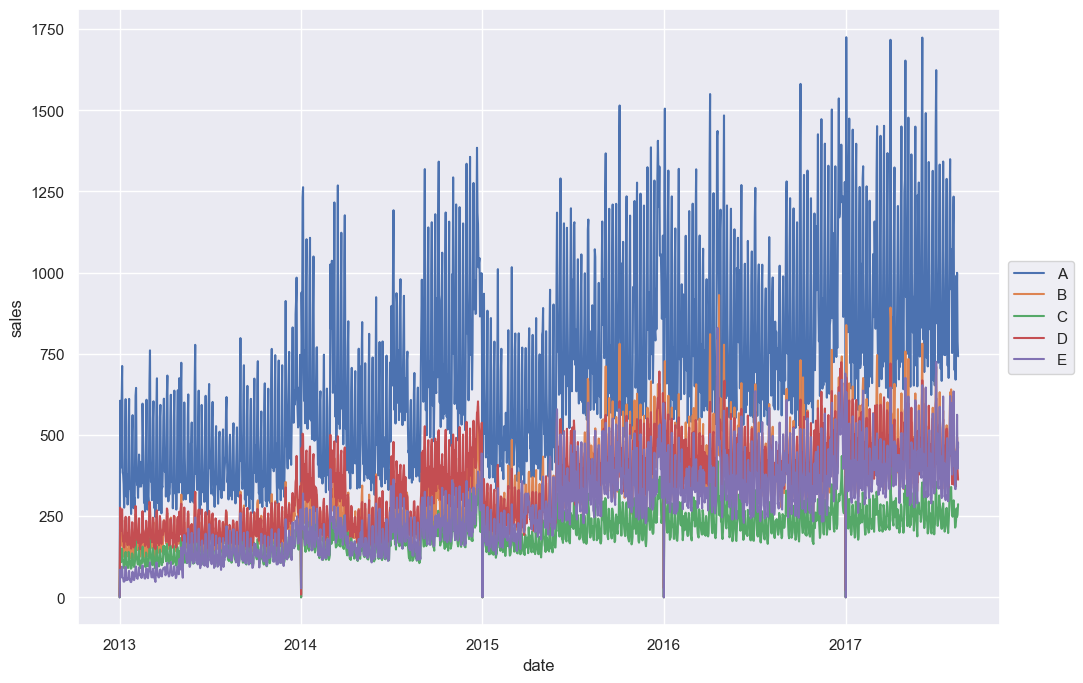

cluster


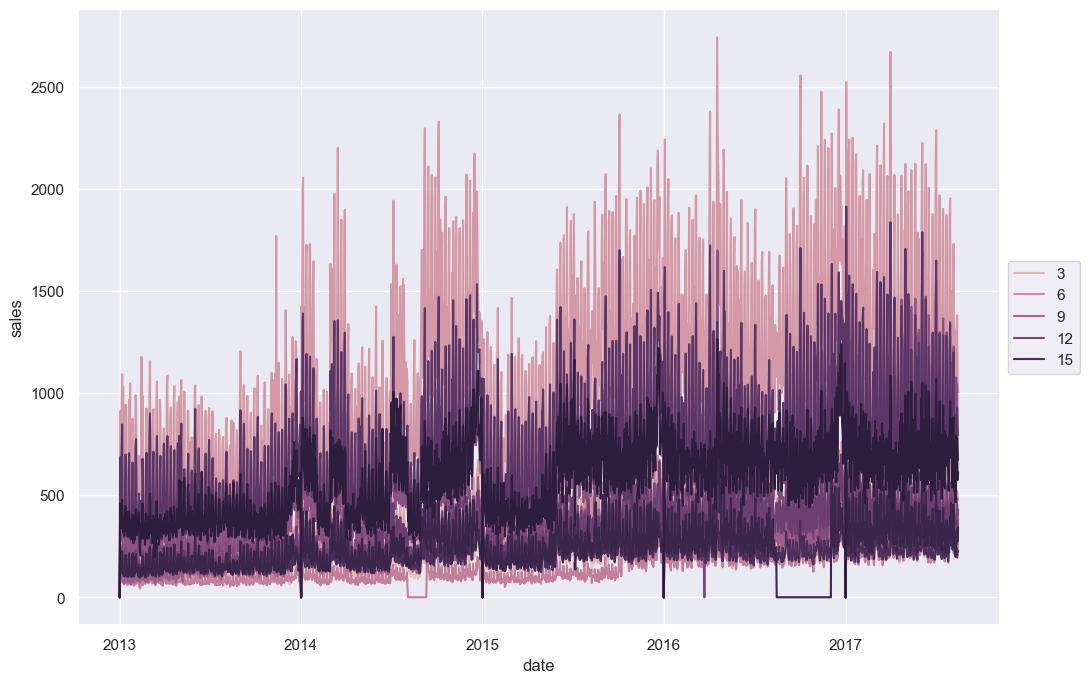

In [32]:
categoricals=[ 'family', 'typeholiday', 'city', 'state', 'typestores', 'cluster']
for cat in categoricals:
    print(cat)
    plot_by_category(train_merged,cat)

day_of_week


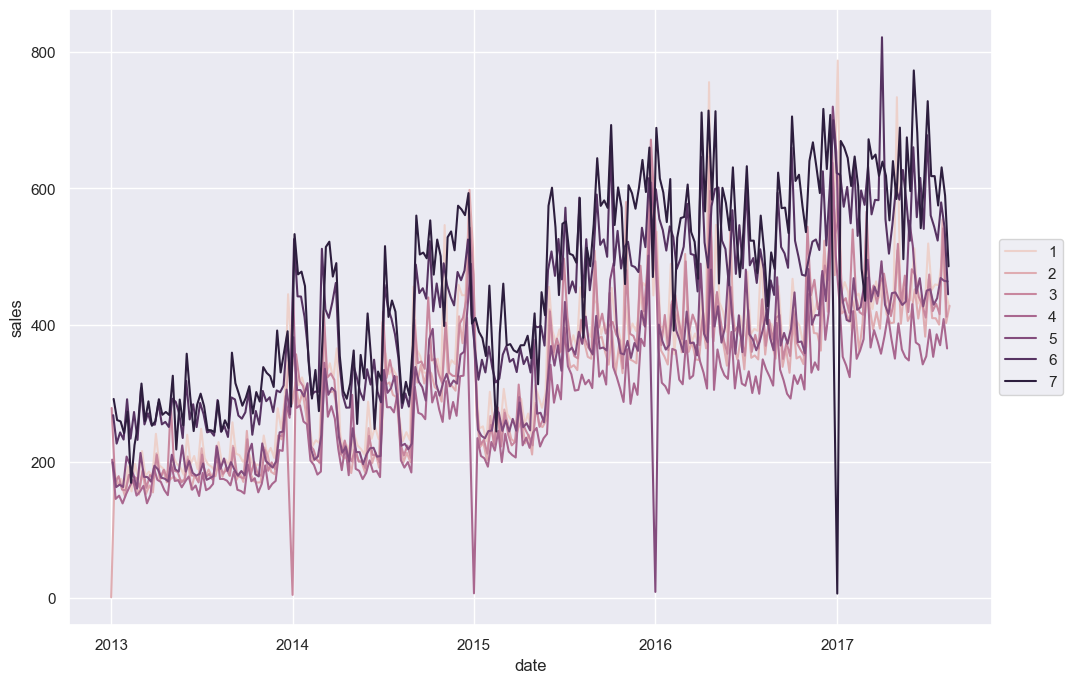

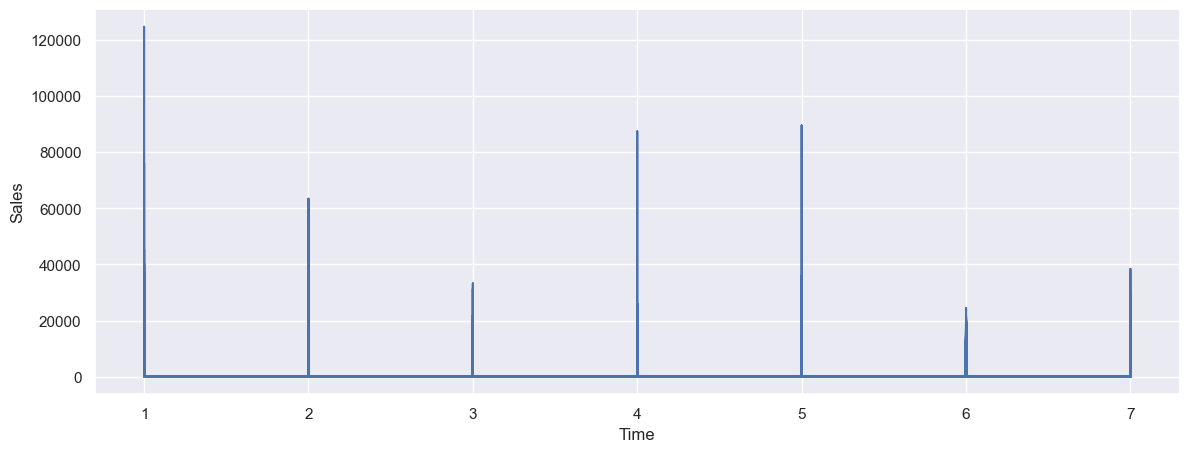

month


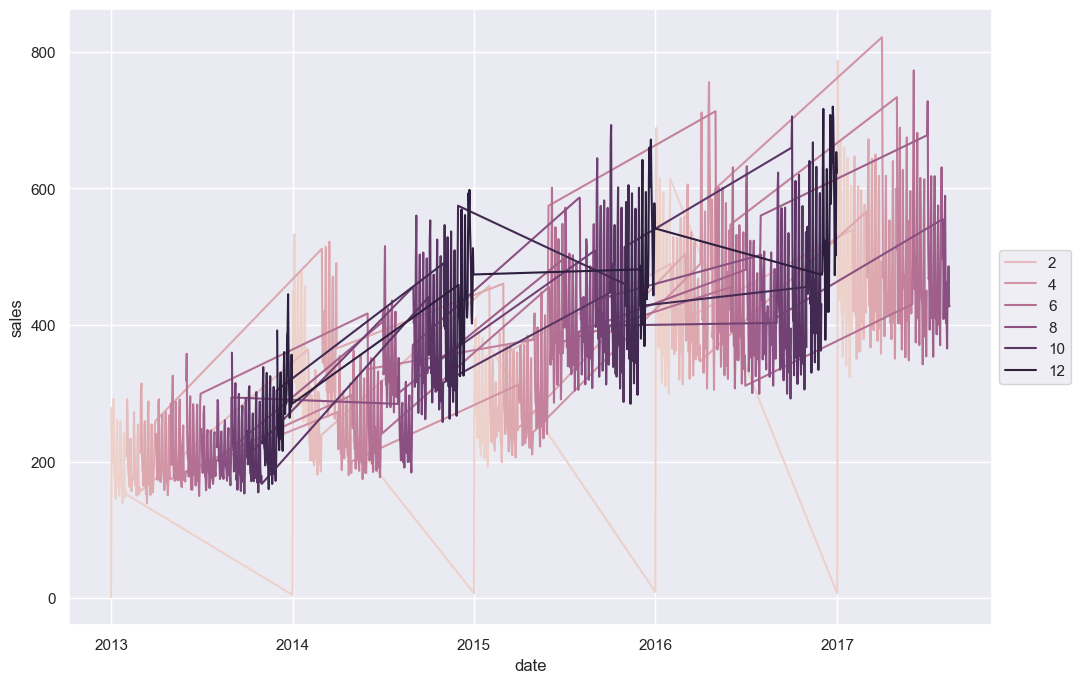

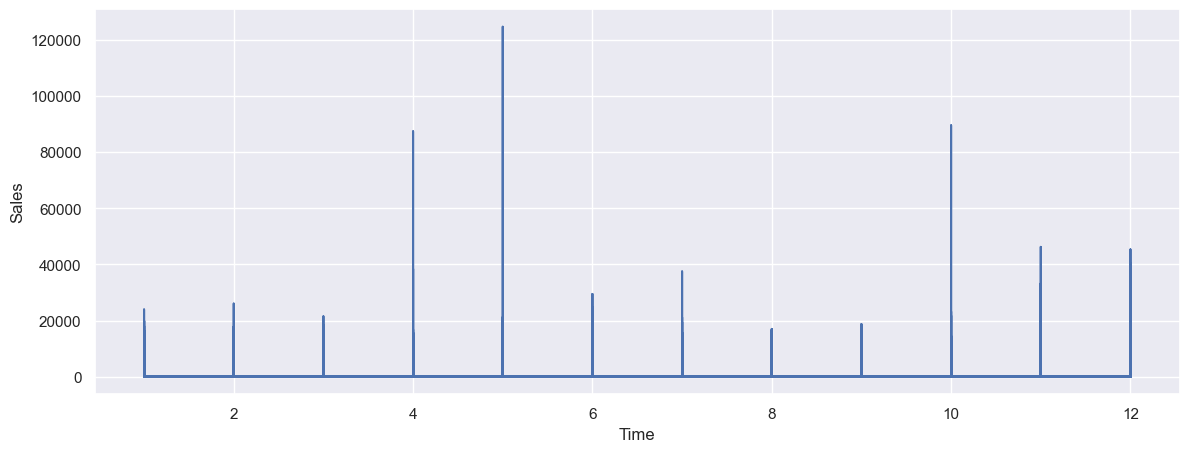

year


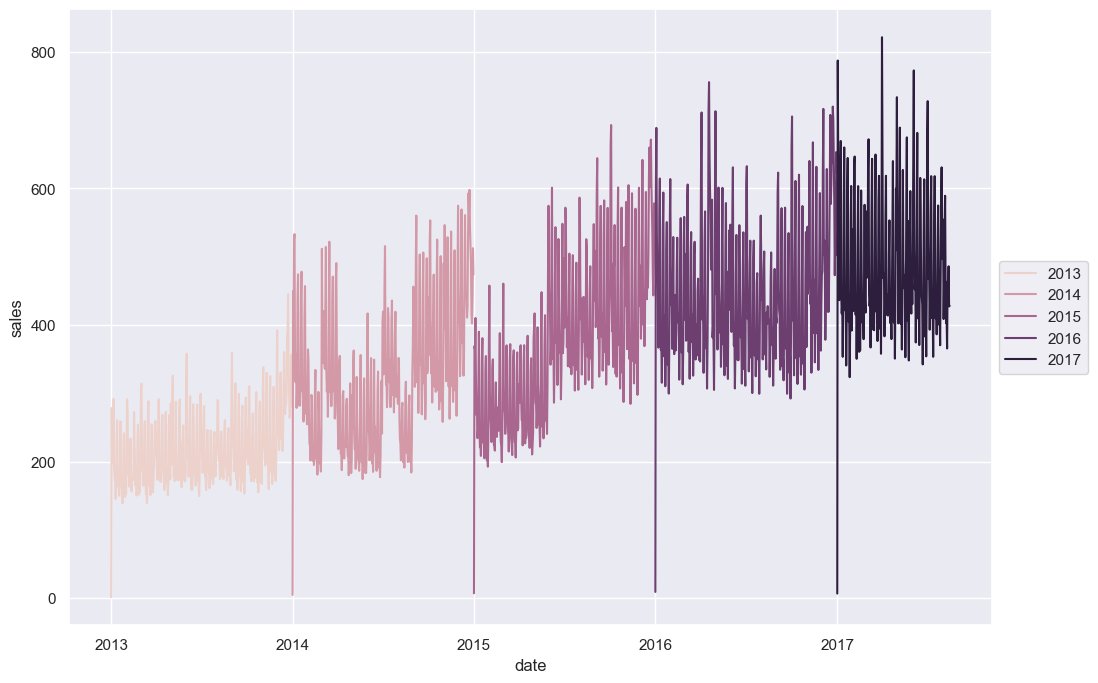

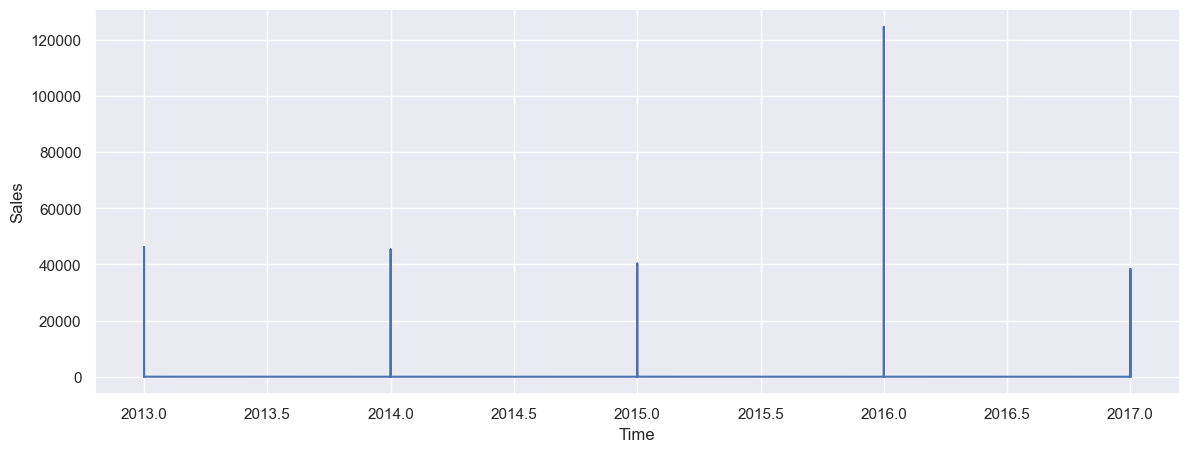

In [33]:
time_features=["day_of_week","month","year"]
for t_feat in time_features:
    print(t_feat)
    plot_by_category(train_merged,t_feat)
    plot_series(train_merged[t_feat], train_merged["sales"], format="-", start=0, end=None)

State and city have very similiar baseline I will use city as it is more specific

In [34]:
# helper function to plot numeric features vs time in comparison to sales vs time
def plot_by_numeric(df,num_cols):
    fig, ax = plt.subplots(figsize=(14,8))
    cols_to_plot=["date","sales",num_cols]
    df=df[cols_to_plot]
    df_grouped=df.groupby(['date']).agg({'sales': 'mean', num_cols:'mean'}).reset_index()
    g1=sns.lineplot(data=df_grouped, x ="date", y='sales',legend='full', ax=ax)
    g2=sns.lineplot(data=df_grouped, x ="date", y=num_cols,legend='full', ax=ax)
    g1.set(yscale='log')
    g2.set(yscale='log')
    plt.show()
    plt.close()

onpromotion


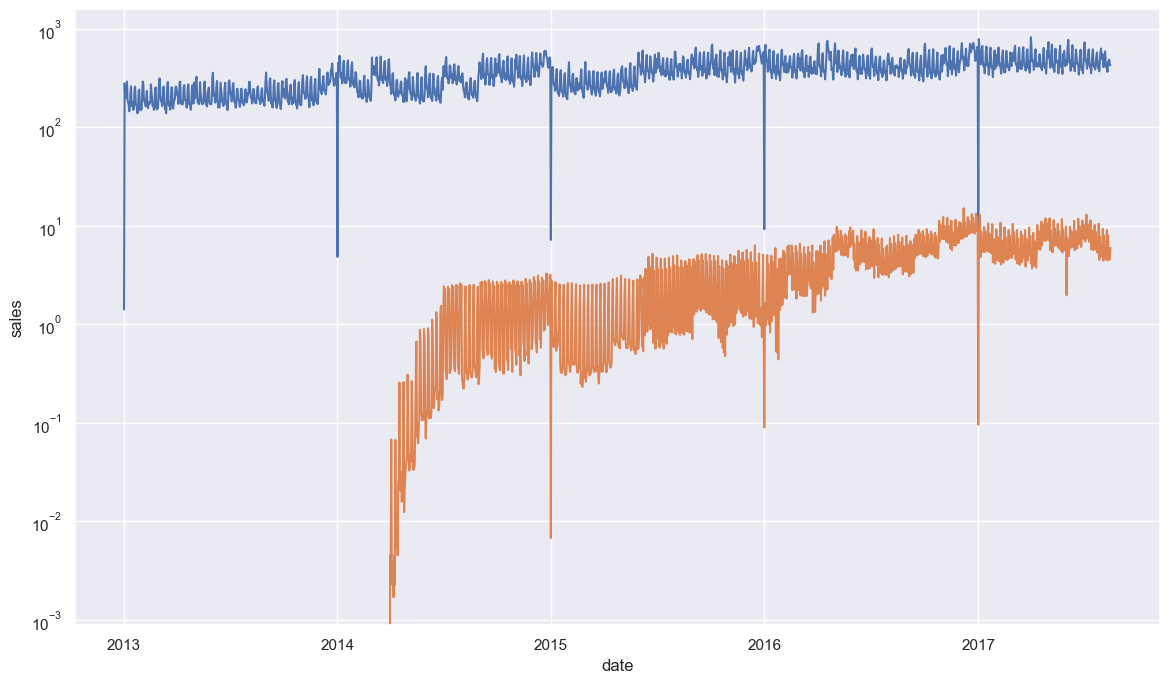

dcoilwtico


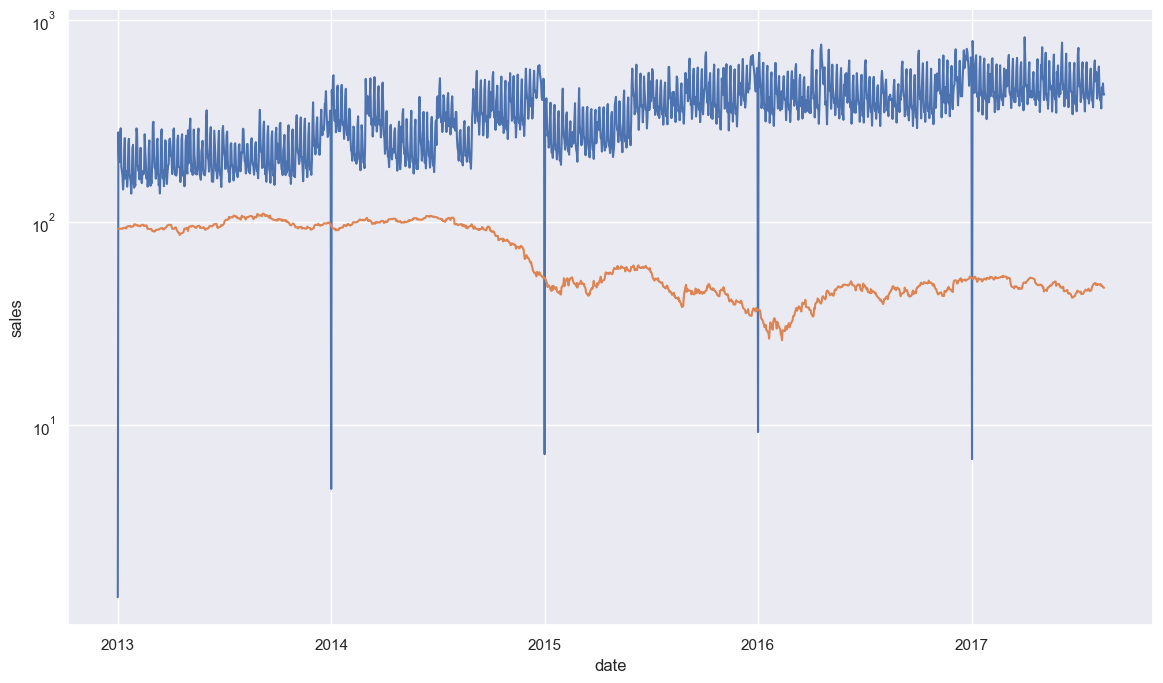

In [35]:
numerics=['onpromotion','dcoilwtico']
for num_col in numerics:
    print(num_col)
    plot_by_numeric(train_merged,num_col)

In [36]:
#helper function to plot numeric features vs time in comparison to sales vs time zooming in after 2017.01.01
def plot_by_numeric_last_year(df,num_cols):
    fig, ax = plt.subplots(figsize=(14,8))
    cols_to_plot=["date","sales",num_cols]
    df=df[cols_to_plot]
    df=df[train["date"] >=pd.to_datetime("2017-01-01")]
    df_grouped=df.groupby(['date']).agg({'sales': 'mean', num_cols:'mean'}).reset_index()
    g1=sns.lineplot(data=df_grouped, x ="date", y='sales', ax=ax)
    g2=sns.lineplot(data=df_grouped, x ="date", y=num_cols, ax=ax)
    g1.set(yscale='log')
    g2.set(yscale='log')
    plt.show()
    plt.close()

onpromotion


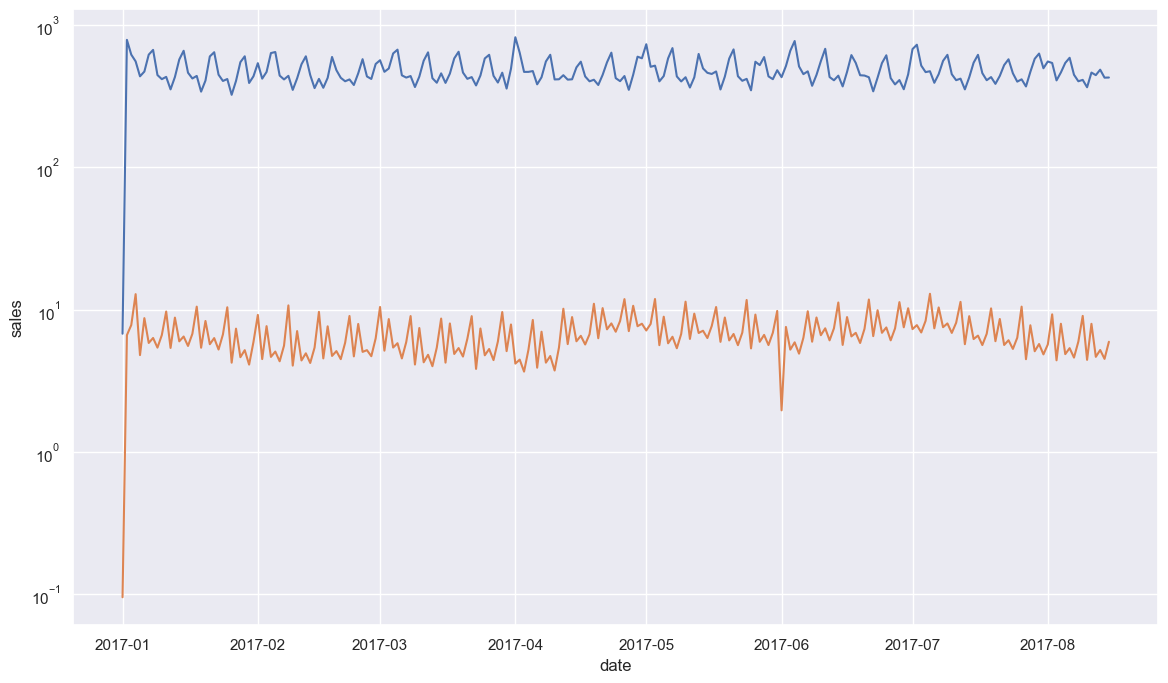

dcoilwtico


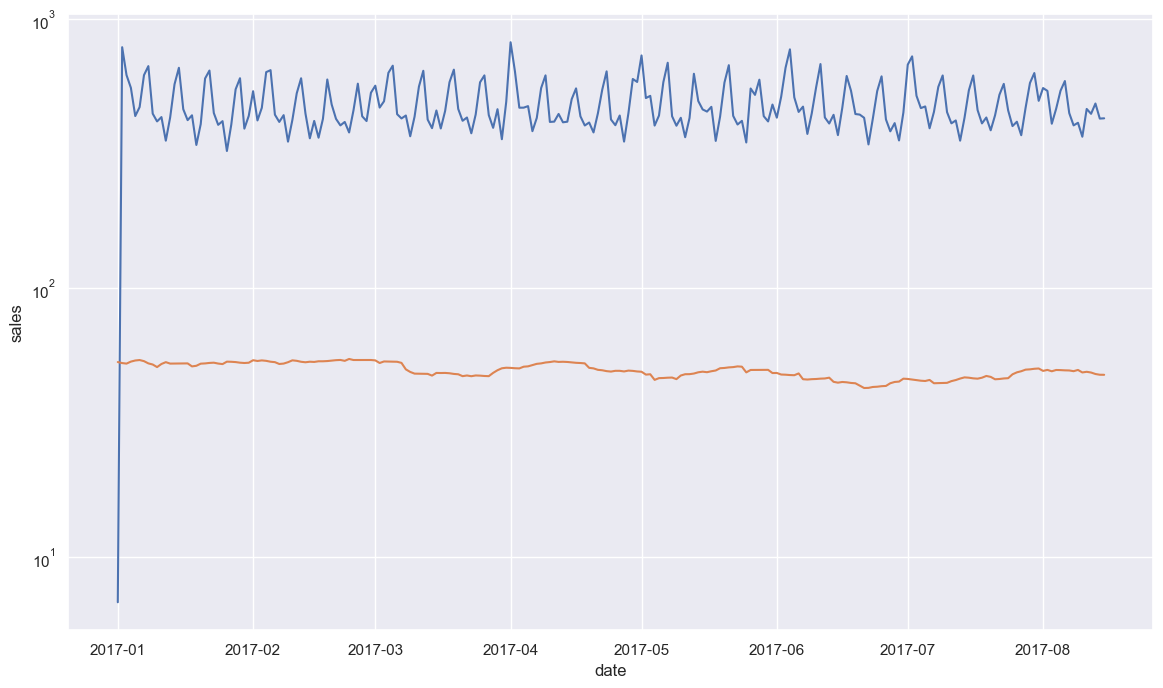

In [37]:
numerics=['onpromotion','dcoilwtico']
for num_col in numerics:
    print(num_col)
    plot_by_numeric_last_year(train_merged,num_col)

In [38]:
# helper function to extract the features I potentially use for training a model
def extract_features(df):
    print(f"Shape before extracting {df.shape}")
    useful_features=['date', 'family','onpromotion','typeholiday', 'dcoilwtico','city', 'typestores', 'cluster','day_of_week', 'month','year']
    if "sales"in df.columns:
        df=df[useful_features+["sales"]]
    else:
        df=df[useful_features]
    print(f"Shape after extracting{df.shape}")
    return df

In [39]:
train_merged=extract_features(train_merged)
test_merged=extract_features(test_merged)

Shape before extracting (3000888, 13)
Shape after extracting(3000888, 12)
Shape before extracting (28512, 12)
Shape after extracting(28512, 11)


In [40]:
# converting category columns to str type
category_columns=['family', 'typeholiday', 'city', 'typestores', 'cluster']
for column in category_columns:
    train_merged[column] = train_merged[column].astype('str')
    test_merged[column] = test_merged[column].astype('str')

C:\Users\pc\AppData\Local\Temp\ipykernel_10064\1636804594.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_merged[column] = train_merged[column].astype('str')
C:\Users\pc\AppData\Local\Temp\ipykernel_10064\1636804594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_merged[column] = test_merged[column].astype('str')
C:\Users\pc\AppData\Local\Temp\ipykernel_10064\1636804594.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [41]:
# converting extracted time features to float
time_columns=["month","day_of_week","year"]
for column in time_columns:
    train_merged[column] = train_merged[column].astype('float')
    test_merged[column] = test_merged[column].astype('float')

C:\Users\pc\AppData\Local\Temp\ipykernel_10064\1330607520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_merged[column] = train_merged[column].astype('float')
C:\Users\pc\AppData\Local\Temp\ipykernel_10064\1330607520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_merged[column] = test_merged[column].astype('float')
C:\Users\pc\AppData\Local\Temp\ipykernel_10064\1330607520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [42]:
# saving them in to a csv
train_merged.to_csv('C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\train_merged.csv', index=False)
test_merged.to_csv('C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\test_merged.csv', index=False)

# Common libs & Methods for ML

In [43]:
#main modules for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import TargetEncoder

#main modules for designing ML pipeliens
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer 
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

#main module for evaluation
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error,r2_score

In [44]:
# helper function to calculate regression metrics
def calcMetrics(testActualVal, predictions):
    #regression evaluation measures
    data={"RMSLE":[mean_squared_log_error(testActualVal, predictions)**0.5],
         "MAE":[mean_absolute_error(testActualVal, predictions)],
         "RMSE":[mean_squared_error(testActualVal, predictions)**0.5],
         "R2":[r2_score(testActualVal, predictions)]}
    metric_df=pd.DataFrame(data)
    return metric_df

# XGBoost

Preprocessing for XGBoost

In [45]:
# helper function to split datset in to train and validation, validation set involves samples after 01.01.2017
def split(df):
    useful_features=['date', 'family','typeholiday','onpromotion', 'dcoilwtico','city', 'typestores',
                     'cluster','day_of_week', 'month','year']
    val_start_index=df.shape[0]-len(df["date"][df["date"] >=pd.to_datetime("2017-01-01")])
    train = df[:val_start_index]
    val=df[val_start_index:]
    X_train = train[useful_features]
    y_train = train["sales"]
    X_valid = val[useful_features]
    y_valid = val["sales"]
    return X_train, y_train, X_valid, y_valid 

In [46]:
X_train, y_train, X_valid, y_valid =split(train_merged)

In [47]:

#pipeline for target encoding category features
category_feat=Pipeline(steps=[("target_encode",TargetEncoder(target_type="continuous"))])

# helper functions to be able to get feature names out of functional transformer 
def f_out_sin(self,input_features):
    return input_features
def f_out_cos(self,input_features):
    return input_features

# functions to transform time features with sine cosine transformation 
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi),feature_names_out=f_out_sin)

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi), feature_names_out=f_out_cos)

#adding polynomial transformation on sine_cosine transformed time features to capture linear interactions between time features
time_feat=make_pipeline(
                        ColumnTransformer([
                            #("cyclic_day_of_week", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
                            ("day_of_week_sin", sin_transformer(7), ["day_of_week"]),
                            ("day_of_week_cos", cos_transformer(7), ["day_of_week"]),
                            #("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
                            ("month_sin", sin_transformer(12), ["month"]),
                            ("month_cos", cos_transformer(12), ["month"]),
                            ("year_sin", sin_transformer(365), ["year"]),
                            ("year_cos", cos_transformer(365), ["year"]),   
                            ],remainder='drop'),
    #Nystroem(kernel="poly", degree=2,n_jobs=-1, n_components=85, random_state=0),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
# Note: One of my purpose for building this model is to get to get feature importance rating out of it
# therefore I don't want to increase number of features and build a complex model
# If this model be the focus, it might worth trying cyclic spline transformation on time features and kernel approximation to capture
# non linear interactions between time features, this would increase number of features and extend training time and
# increase systems memory requirement for training but as demonstrated in referance from documentation I linked above;
# that approach can be more expressive, the code I commented out is for that approach 

In [48]:
# names of columns to train xgb
col_names_classic_ml=['family', 'typeholiday','onpromotion', 'dcoilwtico', 'city', 'typestores',
           'cluster', 'day_of_week','month','year']

# names of columns after pipeline transformations, 
# note ordering of this list isn't arbitrary.
# I manually adjusted ordering after getting feature names out of pipeline and verfiying ordering 
col_names_classic_ml_transformed=['family', 'typeholiday','city', 'typestores','cluster',
       'day_of_week_sin','day_of_week_cos', 'month_sin', 'month_cos','year_sin', 'year_cos',
       'day_of_week_sin day_of_week_cos','day_of_week_sin month_sin', 'day_of_week_sin month_cos',
       'day_of_week_sin year_sin', 'day_of_week_sin year_cos','day_of_week_cos month_sin',
       'day_of_week_cos month_cos','day_of_week_cos year_sin', 'day_of_week_cos year_cos','month_sin month_cos',
       'month_sin year_sin','month_sin year_cos','month_cos year_sin','month_cos year_cos', 'year_sin year_cos',
       'onpromotion', 'dcoilwtico']

# building the pipeline to perform feature engineering
preprocess_pipe = Pipeline(steps=[
    ('encoder', ColumnTransformer(
                    transformers=[
                        ("category_trans",category_feat,category_columns),
                        ("time_trans",time_feat,["day_of_week","month","year"] ),
                                ],
                                remainder="passthrough", verbose_feature_names_out=True
                            )),
    ('scaler', MinMaxScaler()),
    ("pandarizer2", FunctionTransformer(lambda x: pd.DataFrame(x, columns =  col_names_classic_ml_transformed)))
                            ],verbose = True)

In [49]:
preprocess_pipe.fit(X_train[col_names_classic_ml],y_train)


[Pipeline] ........... (step 1 of 3) Processing encoder, total=   4.9s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.7s
[Pipeline] ....... (step 3 of 3) Processing pandarizer2, total=   0.0s


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_trans',
                                                  Pipeline(steps=[('target_encode',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  ['family', 'typeholiday',
                                                   'city', 'typestores',
                                                   'cluster']),
                                                 ('time_trans',
                                                  Pipeline(steps=[('columntransformer',
                                                                   ColumnTransformer(transformers=[('day_of_week_sin',
                                                                                                    FunctionTransfo...
                                                                                                    FunctionTransformer(feature_names_out=<function f_out_cos at 0x00000155A7082020>,
                                                                                                                        func=<function cos_transformer.<locals>.<lambda> at 0x00000155A70827A0>),
                                                                                                    ['year'])])),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['day_of_week', 'month',
                                                   'year'])])),
                ('scaler', MinMaxScaler()),
                ('pandarizer2',
                 FunctionTransformer(func=<function <lambda> at 0x00000155A7081DA0>))],
         verbose=True)

Checking out to see if feature names passed to pandarizer is in correct order, because getting correct output names is important to determine feature importances

In [50]:
display(preprocess_pipe['encoder'].feature_names_in_)
display(preprocess_pipe['encoder'].get_feature_names_out())

array(['family', 'typeholiday', 'onpromotion', 'dcoilwtico', 'city',
       'typestores', 'cluster', 'day_of_week', 'month', 'year'],
      dtype=object)

array(['category_trans__family', 'category_trans__typeholiday',
       'category_trans__city', 'category_trans__typestores',
       'category_trans__cluster',
       'time_trans__day_of_week_sin__day_of_week',
       'time_trans__day_of_week_cos__day_of_week',
       'time_trans__month_sin__month', 'time_trans__month_cos__month',
       'time_trans__year_sin__year', 'time_trans__year_cos__year',
       'time_trans__day_of_week_sin__day_of_week day_of_week_cos__day_of_week',
       'time_trans__day_of_week_sin__day_of_week month_sin__month',
       'time_trans__day_of_week_sin__day_of_week month_cos__month',
       'time_trans__day_of_week_sin__day_of_week year_sin__year',
       'time_trans__day_of_week_sin__day_of_week year_cos__year',
       'time_trans__day_of_week_cos__day_of_week month_sin__month',
       'time_trans__day_of_week_cos__day_of_week month_cos__month',
       'time_trans__day_of_week_cos__day_of_week year_sin__year',
       'time_trans__day_of_week_cos__day_of_week ye

In [51]:
#fit transform data
preprocess_pipe.fit(X_train[col_names_classic_ml],y_train)
X_train=preprocess_pipe.transform(X_train[col_names_classic_ml])
X_valid=preprocess_pipe.transform(X_valid[col_names_classic_ml])

[Pipeline] ........... (step 1 of 3) Processing encoder, total=   4.9s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.7s
[Pipeline] ....... (step 3 of 3) Processing pandarizer2, total=   0.0s


In [52]:
display(X_train.head(2),X_train.tail(2),X_train.shape )
display(X_valid.head(2),X_valid.tail(2), X_valid.shape)

,family,typeholiday,city,typestores,cluster,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year_sin,...,day_of_week_cos year_sin,day_of_week_cos year_cos,month_sin month_cos,month_sin year_sin,month_sin year_cos,month_cos year_sin,month_cos year_cos,year_sin year_cos,onpromotion,dcoilwtico
0,0.001605,0.031107,0.996633,0.301919,0.191343,1.0,0.356896,0.75,0.933013,1.0,...,0.601947,0.643104,1.0,0.337899,0.25,0.219233,0.066987,0.0,0.0,0.792965
1,0.000012,0.031107,0.996633,0.301919,0.191343,1.0,0.356896,0.75,0.933013,1.0,...,0.601947,0.643104,1.0,0.337899,0.25,0.219233,0.066987,0.0,0.0,0.792965


,family,typeholiday,city,typestores,cluster,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year_sin,...,day_of_week_cos year_sin,day_of_week_cos year_cos,month_sin month_cos,month_sin year_sin,month_sin year_cos,month_cos year_sin,month_cos year_cos,year_sin year_cos,onpromotion,dcoilwtico
2596372,0.000532,0.973207,0.996633,0.244409,0.204526,0.099031,0.801938,0.5,1.0,0.0,...,0.198062,0.200107,0.5,0.5,0.5,0.0,0.003118,1.0,0.000000,0.320941
2596373,0.006072,0.973207,0.996633,0.244409,0.204526,0.099031,0.801938,0.5,1.0,0.0,...,0.198062,0.200107,0.5,0.5,0.5,0.0,0.003118,1.0,0.002699,0.320938


(2596374, 28)

,family,typeholiday,city,typestores,cluster,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year_sin,...,day_of_week_cos year_sin,day_of_week_cos year_cos,month_sin month_cos,month_sin year_sin,month_sin year_cos,month_cos year_sin,month_cos year_cos,year_sin year_cos,onpromotion,dcoilwtico
0,0.001605,0.004687,0.996633,0.301919,0.191343,0.5,1.0,0.75,0.933013,-0.331779,...,-0.061365,0.004684,1.0,0.220837,0.252226,0.016475,0.070843,1.327036,0.0,0.320934
1,0.000012,0.004687,0.996633,0.301919,0.191343,0.5,1.0,0.75,0.933013,-0.331779,...,-0.061365,0.004684,1.0,0.220837,0.252226,0.016475,0.070843,1.327036,0.0,0.320931


,family,typeholiday,city,typestores,cluster,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year_sin,...,day_of_week_cos year_sin,day_of_week_cos year_cos,month_sin month_cos,month_sin year_sin,month_sin year_cos,month_cos year_sin,month_cos year_cos,year_sin year_cos,onpromotion,dcoilwtico
404512,0.000532,0.031107,0.996633,0.244409,0.204526,1.0,0.356896,0.066987,0.25,-0.331779,...,0.656759,0.642062,1.0,0.983525,0.929157,0.779163,0.747774,1.327036,0.010796,0.253228
404513,0.006072,0.031107,0.996633,0.244409,0.204526,1.0,0.356896,0.066987,0.25,-0.331779,...,0.656759,0.642062,1.0,0.983525,0.929157,0.779163,0.747774,1.327036,0.000000,0.253228


(404514, 28)

# Training XGBoost Regressor

In [53]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

In [54]:
# call back to avoid overfitting
early_stop = xgb.callback.EarlyStopping(rounds=10,
                                        metric_name='rmse',
                                        maximize=False,
                                       save_best= True,
                                        )

In [55]:
# training xgboost model
xgboost_v00=XGBRegressor(random_state=seed0,verbosity=0, n_jobs = -1, reg_lambda=0.005, 
                         learning_rate=0.01, device='gpu',
                          n_estimators=5000, objective='reg:squarederror',
                        callbacks=[early_stop])
xgboost_v00.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],verbose=False)

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x00000155A71528D0>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=-1,
             num_parallel_tree=None, random_state=1337, ...)

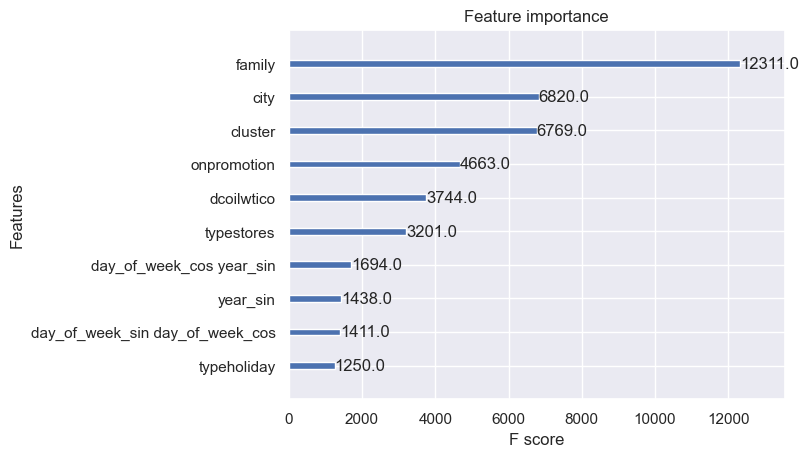

In [56]:
# ploting feature importances
_ = plot_importance(xgboost_v00,max_num_features = 10)

# Measuring Performance of XGBoost Regressor

In [57]:
# creating to dataframe, I will use to visualise predictions vs actual
series_compare=pd.concat([y_train,y_valid], axis=0)
df_compare=pd.DataFrame()
df_compare["actual"]=series_compare
df_compare["date"]=train_merged.date

In [58]:
# predicting validation set
y_pred_xgb = xgboost_v00.predict(X_valid)
# converting negative predictions to 0
y_pred_xgb=np.where(y_pred_xgb<0,0,y_pred_xgb)
# calculating metrics
calcMetrics(y_valid,y_pred_xgb)

,RMSLE,MAE,RMSE,R2
0,0.979517,127.95901,445.647556,0.891861


In [59]:
# additing predictions to comparison dataframe
df_compare["xgb_pred"]=np.nan
df_compare.loc[df_compare.index>=df_compare.shape[0]-len(y_pred_xgb),"xgb_pred"]=y_pred_xgb
df_compare=df_compare.set_index("date")


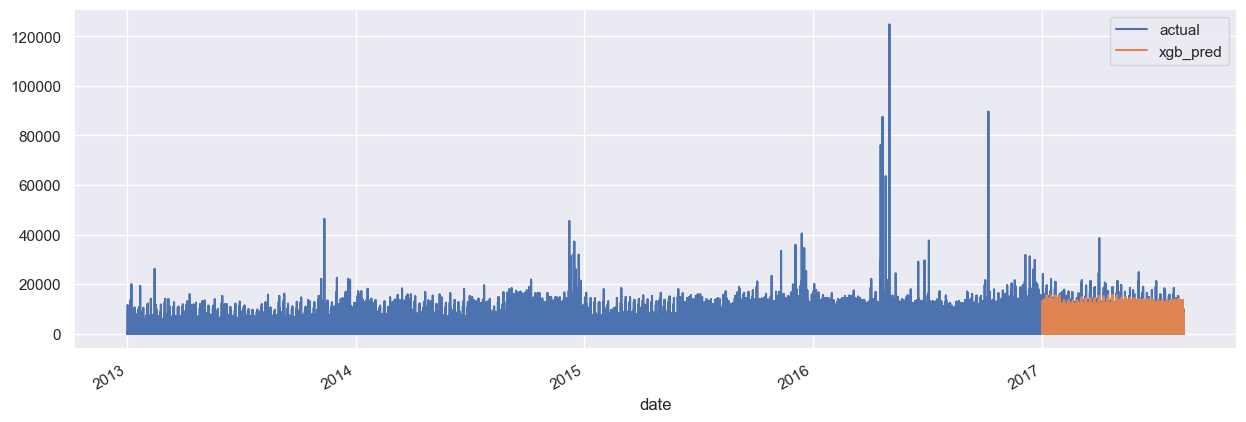

In [61]:
# visualising predictions
prediction= df_compare[['actual','xgb_pred']].plot(figsize=(15, 5))

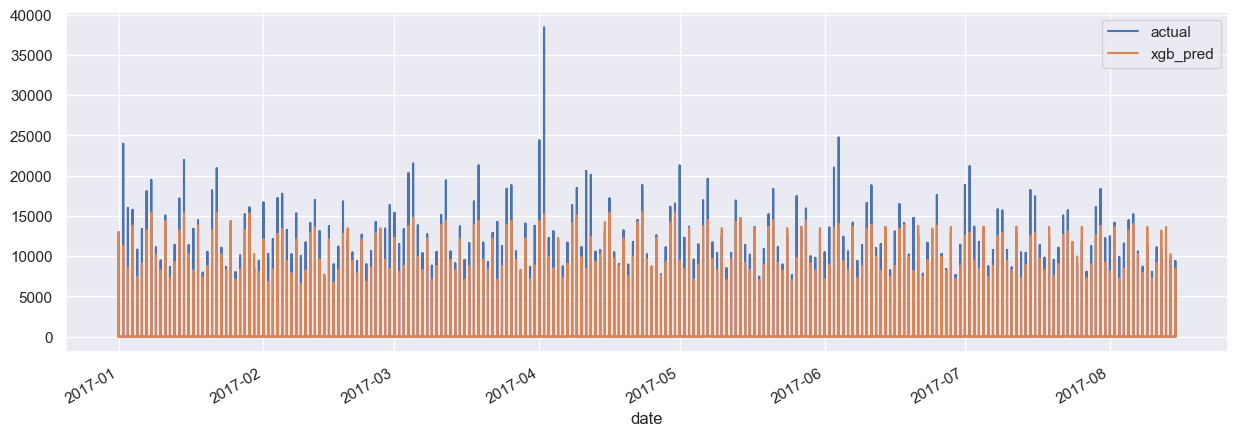

In [62]:
#zooming to 2017 afterwards that was predicted
prediction= df_compare[['actual','xgb_pred']].tail(len(y_pred_xgb)).plot(figsize=(15, 5))

# Predicting Test Set with XGBoost Regressor¶


In [63]:
# preprocessing test set to rdy for inputting to model
X_test=preprocess_pipe.transform(test_merged[col_names_classic_ml])
#predicting testset
y_pred_test_xgb = xgboost_v00.predict(X_test)

In [64]:
# writing predictions to a csv for submission
output = pd.DataFrame({'id': test.id, 'sales': y_pred_test_xgb})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!


In [86]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


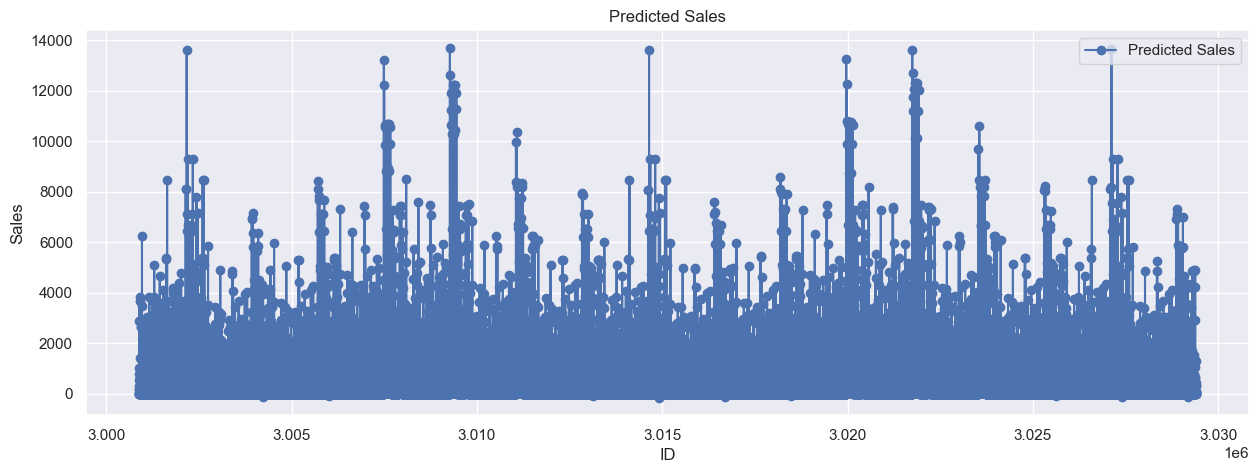

In [65]:
import matplotlib.pyplot as plt

# ... (votre code précédent)

# visualiser les résultats
plt.figure(figsize=(15, 5))
plt.plot(test['id'], y_pred_test_xgb, label='Predicted Sales', marker='o')
plt.title('Predicted Sales')
plt.xlabel('ID')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

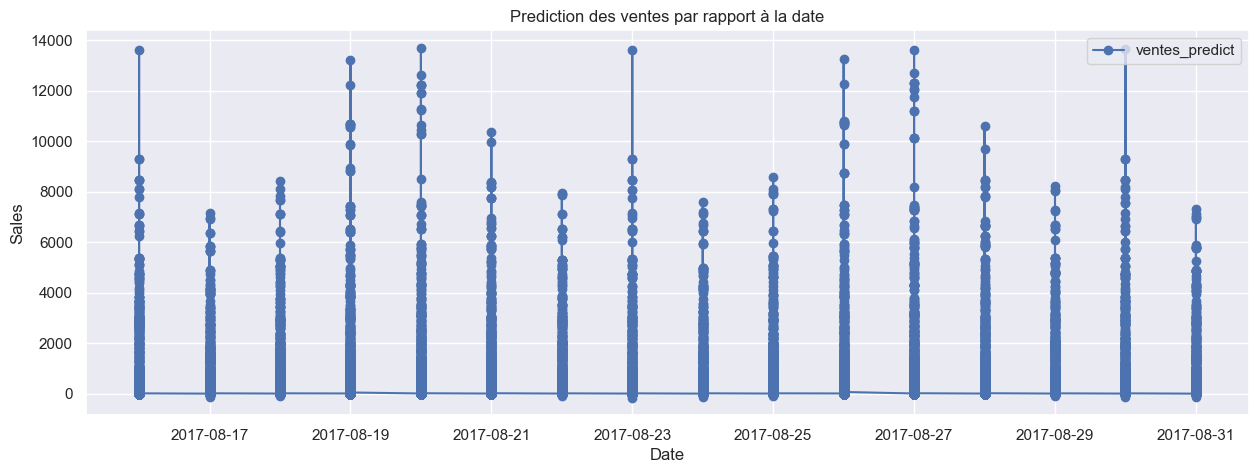

In [100]:
import matplotlib.pyplot as plt

# ... (votre code précédent)

# Visualize the results - Comparing predicted sales with respect to date
plt.figure(figsize=(15, 5))

# Plot predicted sales with respect to date
plt.plot(test['date'], y_pred_test_xgb, label='ventes_predict', marker='o')

# Set plot title and axis labels
plt.title('Prediction des ventes par rapport à la date')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add legend
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()


In [97]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [98]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [96]:
import joblib

# Assuming your trained XGBoost model is stored in a variable named 'xgb_model'
# Replace 'xgb_model' with the actual variable name you used to store your model

# Save the model to a file
joblib.dump(xgboost_v00, r'C:\Users\pc\Desktop\projet_class\Python_project\store-sales-time-series-forecasting\xgboost_model.pkl')

# To load the model back later:
# loaded_model = joblib.load('xgboost_model.pkl')


['C:\\Users\\pc\\Desktop\\projet_class\\Python_project\\store-sales-time-series-forecasting\\xgboost_model.pkl']